In [2]:
# std packages
%matplotlib inline
import numpy as np
import scipy.interpolate as interp
import scipy.signal as sig
import scipy.optimize as opt
import scipy.integrate as integ
import scipy.linalg as sla
import scipy.stats as stats
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
from matplotlib.ticker import LogLocator
import h5py as h5

plt.rc('figure', figsize=(9, 7))
plt.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.serif': ['Georgia'],
                     'mathtext.fontset': 'cm',
                     'lines.linewidth': 2.5,
                     'font.size': 20,
                     'xtick.labelsize': 'large',
                     'ytick.labelsize': 'large',
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'axes.labelsize': 'large',
                     'axes.titlesize': 'large',
                     'axes.grid': True,
                     'grid.alpha': 0.5,
                     'lines.markersize': 12,
                     'legend.borderpad': 0.2,
                     'legend.fancybox': True,
                     'legend.fontsize': 17,
                     'legend.framealpha': 0.7,
                     'legend.handletextpad': 0.5,
                     'legend.labelspacing': 0.2,
                     'legend.loc': 'best',
                     'savefig.bbox': 'tight',
                     'savefig.pad_inches': 0.05,
                     'savefig.dpi': 80,
                     'pdf.compression': 9})

from myConstants import *

In [3]:
def get_inst_t_gw_from_a_orb(M1, M2, a_orb, e):
    Mt=M1+M2
    mu=M1*M2/(M1+M2)
    
    G3muMt2_c5a3 = (G*mu/c**2./a_orb) * (G*Mt/c**2./a_orb)**2. * c
    
    inv_t_gw = (64./5.)*(G3muMt2_c5a3/a_orb) \
                * (1.+73./24.*e**2+37./96.*e**4.)/(1.-e**2.)**(3.5)
    t_gw = 1./inv_t_gw
    return t_gw

def get_epsilon_GR(M1, M2, M3, ai, ao, eo=0):
    M12 = M1+M2
    ep_GR = 3.*(G*M12/c**2./ai) * (M12/M3)*(ao/ai)**3.
    return ep_GR

def get_epsilon_BR(M1, M2, M3, ai, ao, eo=0):
    mu_i = M1*M2/(M1+M2)
    mu_o = (M1+M2)*M3/(M1+M2+M3)
    ep_BR=(mu_i/mu_o) * np.sqrt((M1+M2)/(M1+M2+M3) * (ai/ao/(1.-eo**2.)))
    return ep_BR

def find_ei_max_vs_Ii_0(Ii_0, \
        M1, M2, M3, ai, ao, eo=0):
    cI0 = np.cos(Ii_0)
    ep_GR = get_epsilon_GR(M1, M2, M3, ai, ao, eo)
    ep_BR = get_epsilon_BR(M1, M2, M3, ai, ao, eo)
    
    def resi(ei_max):
        jj = np.sqrt(1.-ei_max**2.)
        resi = 0.375 * ((jj+1)/jj)\
            * (5*(cI0+0.5*ep_BR)**2.\
               - (3.+4.*ep_BR*cI0+2.25*ep_BR**2.)*jj**2.\
               + (ep_BR**2.*jj**4.))\
            + ep_GR
        return resi
    
    ei_max = opt.ridder(resi, 0., 1.-1.e-18)
    return ei_max

def find_ei_lim_over_Ii_0(M1, M2, M3, ai, ao, eo=0):
    ep_GR = get_epsilon_GR(M1, M2, M3, ai, ao, eo)
    ep_BR = get_epsilon_BR(M1, M2, M3, ai, ao, eo)
    
    def resi(ei_lim):
        jj = np.sqrt(1.-ei_lim**2.)
        resi = 0.375*(jj+1.)*jj\
                * (-3. + 0.25*ep_BR**2.*(0.8*jj**2.-1))\
            + ep_GR
        return resi
    
    ei_lim = opt.ridder(resi, 0., 1.)
    return ei_lim

def find_ei_lim_t_gw_cut(M1, M2, M3, ai, ao, eo=0):
    ei_lim_no_diss = find_ei_lim_over_Ii_0(M1, M2, M3, ai, ao, eo=0)
    omega_i = np.sqrt(G*(M1+M2)/ai**3.)
    t_lk = 1./omega_i * ((M1+M2)/M3) * (ao*np.sqrt(1.-eo**2.)/ai)**3.
    
    def resi(ei):
        t_gw_inst = get_inst_t_gw_from_a_orb(M1, M2, ai, ei)
        t_lk_inst = t_lk * np.sqrt(1.-ei**2.)
        resi = (t_gw_inst - t_lk_inst)/t_lk
        return resi

    try:
        ei_lim=opt.ridder(resi, 1.e-12, ei_lim_no_diss)
    except ValueError:
        ei_lim = ei_lim_no_diss
    return ei_lim

def find_ei_lim_cons_ref(M1, M2, M3, ai, ao, eo=0):
    Mt = M1+M2
    ei_lim = 1.\
            -32./9. * (G/c**2.)**2.*Mt**4.*M3**(-2.)\
                *ai**(-8.)*(ao*np.sqrt(1.-eo**2.))**6.
    return ei_lim

def find_ei_lim_t_gw_cut_ref(M1, M2, M3, ai, ao, eo=0):
    Mt = M1+M2
    mu = M1*M2/Mt
    ei_lim = 1.\
            -1.9*(G/c**2.)**(5./6.)*mu**(1./3.)*Mt**(5./6.)*M3**(-1./3.)\
                *ai**(-11/6.)*(ao*np.sqrt(1-eo**2.))
    return ei_lim
    
def find_Tgw_min_vs_Ii_0(Ii_0, \
        M1, M2, M3, ai, ao, eo=0):
    ei_max = find_ei_max_vs_Ii_0(Ii_0, \
        M1, M2, M3, ai, ao, eo)
    
    # note t_gw_min is not simply given by instant. merger time at e_max
    # but needs 1/\sqrt(1-e**2) more time
    t_gw_min = get_inst_t_gw_from_a_orb(M1, M2, ai, 0)
    t_gw_min *= (1.-ei_max**2.)**3.
    return t_gw_min

def find_Tgw_lim_over_Ii_0(M1, M2, M3, ai, ao, eo=0):
    ei_lim = find_ei_lim_over_Ii_0(M1, M2, M3, ai, ao, eo)
    t_gw_lim = get_inst_t_gw_from_a_orb(M1, M2, ai, 0)
    t_gw_lim *= (1.-ei_lim**2.)**3.
    return t_gw_lim

def find_merger_window(Tgw_trgt, \
                      M1, M2, M3, ai, ao, eo=0.):
    def resi(Ii_0):
        Tgw = find_Tgw_min_vs_Ii_0(Ii_0, \
            M1, M2, M3, ai, ao, eo)
        resi = 1.-Tgw/Tgw_trgt
#         print(Ii_0*180./np.pi, resi)
        return resi
    ep_GR = get_epsilon_GR(M1, M2, M3, ai, ao, eo)
    ep_BR = get_epsilon_BR(M1, M2, M3, ai, ao, eo)
    
    e_lim = find_ei_lim_over_Ii_0(M1, M2, M3, ai, ao, eo)
    j_lim = np.sqrt(1.-e_lim**2.)
    I_lim = 0.5*ep_BR*(0.8*j_lim**2.-1.)
    I_lim = np.arccos(I_lim)
    
    I_mm = 0.1*(-ep_BR\
                +np.sqrt(ep_BR**2.+60.-80.*ep_GR/3.))
    I_mm = np.arccos(I_mm)
    I_pp = 0.1*(-ep_BR\
                -np.sqrt(ep_BR**2.+60.-80.*ep_GR/3.))
    I_pp = np.arccos(I_pp)
#     print(I_mm*180./np.pi, I_pp*180./np.pi, I_lim*180./np.pi)
    I_m = opt.ridder(resi, 0.5*(I_lim+I_mm), I_lim)
    I_p = opt.ridder(resi, I_lim, 0.5*(I_lim+I_pp))
#     I_m = opt.ridder(resi, I_lim - 5.*np.pi/180., I_lim)
#     I_p = opt.ridder(resi, I_lim, I_lim + 5.*np.pi/180.)
#     print(I_m*180./np.pi, I_p*180./np.pi)
    return I_m, I_p

def check_LK_exc(M1, M2, M3, ai, ao, eo=0):
    ep_GR = get_epsilon_GR(M1, M2, M3, ai, ao, eo)
    ep_BR = get_epsilon_BR(M1, M2, M3, ai, ao, eo)
    
    flag = 2.25+3.*ep_BR**2./80. - ep_GR
    return flag

def check_stability(M1, M2, M3, ai, ao, eo=0):
    flag =ao/ai - 2.8*(1.-0.3*0.5)*(1.+M3/(M1+M2))**0.4*(1.+eo)**0.4/(1.-eo)**1.2
    return flag

def check_DA_given_ei_max(ei_max, \
                          M1, M2, M3, ai, ao, eo=0):
    M12 = M1+M2
    M123 = M1+M2+M3
    
    omega_i = np.sqrt(G*M12/ai**3.)
    omega_o = np.sqrt(G*M123/ao**3.)
    
    Tlk = 1./omega_i * (M12/M3) * (ao*np.sqrt(1.-eo**2.)/ai)**3.
    flag = Tlk * np.sqrt(1.-ei_max**2.) - 2.*np.pi/omega_o
    return flag

def evol_logL_vs_loga(loga_Mt, logL_Mt, par_aL):
    M1, M2= par_aL
    Mt=M1+M2
    mu=M1*M2/Mt
    
    r_Mt = G*Mt/c**2.
    S_Mt = G*Mt**2./c
    
    a_orb = np.exp(loga_Mt)*r_Mt
    L_orb = np.exp(logL_Mt)*S_Mt
    eff = L_orb/(mu*np.sqrt(G*Mt*a_orb))
    e_orb = np.sqrt(1.-eff**2.)
    
    G3muMt2_c5a3 = (G*mu/c**2./a_orb) * (G*Mt/c**2./a_orb)**2. * c #G**3.*mu*Mt**2./c**5./a_orb**3.
    e2 = e_orb**2.
    e4 = e_orb**4.
    
    da = - (64./5.) * (G3muMt2_c5a3)\
          * (1. + 73./24.*e2 + 37./96.*e4)/(eff**7.)    
    dL = - (32./5.*G3muMt2_c5a3*np.sqrt(G)) * mu *np.sqrt(M1+M2) / np.sqrt(a_orb) \
          * (1.+0.875*e2)/(eff**4.)
    
    dLda = dL/da
    dlogL_dloga = a_orb/L_orb * dL/da
    return dlogL_dloga
    

In [9]:
M1, M2 = 85.*Ms, 65.*Ms
M3 = 1e9 * Ms
ai = 3. * AU
ao = 0.06*pc

ei_lim_c = find_ei_lim_over_Ii_0(M1, M2, M3, ai, ao, eo=0)
print(1.-ei_lim_c)

ei_lim = find_ei_lim_t_gw_cut(M1, M2, M3, ai, ao, eo=0)
print(1.-ei_lim)

print('%e'%(find_Tgw_lim_over_Ii_0(M1, M2, M3, ai, ao, eo=0)/P_yr))
print('%e'%(get_inst_t_gw_from_a_orb(M1, M2, ai, 0)*(1.-ei_lim**2.)**3/P_yr))

9.347169411177969e-05
0.00014634531366064518
8.200856e+02
3.147175e+03


In [11]:
Mt = 150.*Ms
r_Mt = G*Mt/c**2.
print(300*r_Mt/AU, 0.3/50)
print(np.sqrt(G*Mt/(600.*r_Mt)**3.)/np.pi)
print(0.06*pc/12000/AU)


0.00044418995979042747 0.006
0.029313311160767495
1.031316844919786


1.480707837081499e-06 0.01559175672866517
Max eccentricity: 9.347169e-05
GW merger timescale: 8.200856e+02 [yr]
86.8000241192773 93.20006042969419
87.63401088620556


/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in double_scalars


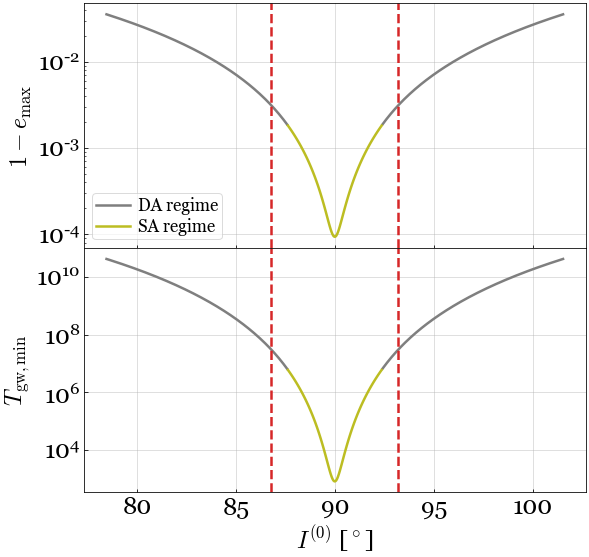

In [72]:
M1, M2, M3 = 85.*Ms, 65.*Ms, 1e9*Ms
ai, ao = 3.*AU, 0.06*pc
eo = 0
nPt = 500

ep_BR = get_epsilon_BR(M1, M2, M3, ai, ao, eo)
ep_GR = get_epsilon_GR(M1, M2, M3, ai, ao, eo)
print(ep_BR, ep_GR)

cI0=np.linspace(-0.2, 0.2, nPt)
I0=np.arccos(cI0)
ei_max = np.zeros(nPt)
# Tgw_min_ref=np.zeros(nPt)
Tgw_min = np.zeros(nPt)
flag_DA = np.zeros(nPt)

for i in range(nPt):
    Ii_0 = np.arccos(cI0[i])
    ei_max[i] = find_ei_max_vs_Ii_0(Ii_0, \
                    M1, M2, M3, ai, ao, eo)
    Tgw_min[i] = find_Tgw_min_vs_Ii_0(Ii_0, \
                    M1, M2, M3, ai, ao, eo)
    flag_DA[i] = check_DA_given_ei_max(ei_max[i], \
                    M1, M2, M3, ai, ao, eo)
    
ei_lim = find_ei_lim_over_Ii_0(M1, M2, M3, ai, ao, eo)
print('Max eccentricity: %e'%(1.-ei_lim))
Tgw_lim = find_Tgw_lim_over_Ii_0(M1, M2, M3, ai, ao, eo)
print('GW merger timescale: %e [yr]'%(Tgw_lim/P_yr))

I_m_Gyr, I_p_Gyr = find_merger_window(3.e7*P_yr, \
                        M1, M2, M3, ai, ao, eo)
print(I_m_Gyr*180./np.pi, I_p_Gyr*180./np.pi)

idx_DA1 = (flag_DA>0) & (I0<np.pi/2)
idx_DA2 = (flag_DA>0) & (I0>np.pi/2)
idx_SA = flag_DA<0 
print(I0[idx_SA][-1]*180./np.pi)

fig=plt.figure(figsize=(9,9))
ax=fig.add_subplot(211)
ax.semilogy(I0[idx_DA1]*180./np.pi, 1.-ei_max[idx_DA1], color='tab:grey', label=r'DA regime')
ax.semilogy(I0[idx_DA2]*180./np.pi, 1.-ei_max[idx_DA2], color='tab:grey')
ax.semilogy(I0[idx_SA]*180./np.pi, 1.-ei_max[idx_SA], color='tab:olive', label=r'SA regime')
# ax.axhline(1.-ei_lim, color='tab:grey', ls='--')
ax.axvline(I_m_Gyr*180./np.pi, ls='--', color='tab:red')
ax.axvline(I_p_Gyr*180./np.pi, ls='--', color='tab:red')
ax.set_ylabel(r'$1-e_{\rm max}$')
ax.xaxis.set_ticklabels([])
ax.legend()

ax=fig.add_subplot(212)
ax.semilogy(I0[idx_DA1]*180./np.pi, Tgw_min[idx_DA1]/P_yr, color='tab:grey')
ax.semilogy(I0[idx_DA2]*180./np.pi, Tgw_min[idx_DA2]/P_yr, color='tab:grey')
ax.semilogy(I0[idx_SA]*180./np.pi, Tgw_min[idx_SA]/P_yr, color='tab:olive')
# ax.semilogy(I0*180./np.pi, Tgw_min_ref/P_yr, color='tab:green')
# ax.axhline(Tgw_lim/P_yr, color='tab:grey', ls='--')
ax.axvline(I_m_Gyr*180./np.pi, ls='--', color='tab:red')
ax.axvline(I_p_Gyr*180./np.pi, ls='--', color='tab:red')
ax.set_ylabel(r'$T_{\rm gw, min}$')
ax.set_xlabel(r'$I^{(0)}$ [$^\circ$]')
plt.subplots_adjust(hspace=0)
# plt.savefig('/home/hang.yu/public_html/astro/LK_evol/max_ecc_Tm_vs_I0.pdf')

1.480707837081499e-06 0.0015591756728665167
Max eccentricity: 9.577549e-07
GW merger timescale: 8.823529e+00 [yr]
1.480707837081499e-06 0.01559175672866517


/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Max eccentricity: 9.347169e-05
GW merger timescale: 8.200856e+02 [yr]
1.480707837081499e-06 0.15591756728665168
Max eccentricity: 7.639580e-03
GW merger timescale: 4.426923e+04 [yr]


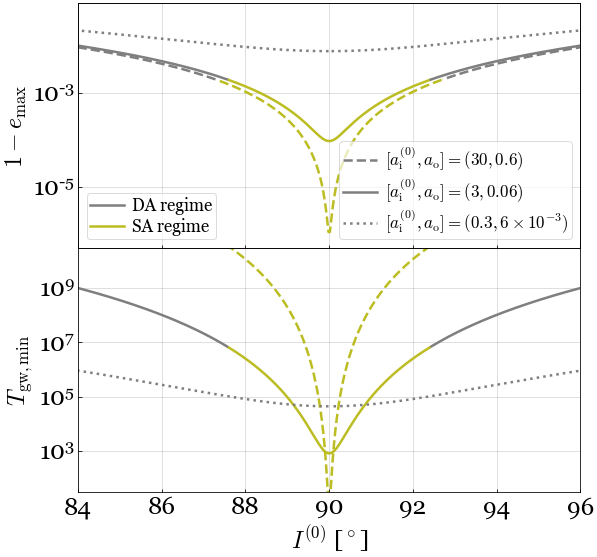

In [30]:
M1, M2, M3 = 85.*Ms, 65.*Ms, 1e9*Ms
eo = 0
nPt = 500

ai_list = np.array([30., 3., 0.3])*AU
ao_list = np.array([0.6, 0.06, 0.006])*pc

fig = plt.figure(figsize=(9,9))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ls=['--', '-', ':']

for j in range(len(ai_list)):
    ai, ao = ai_list[j], ao_list[j]
    
    ep_BR = get_epsilon_BR(M1, M2, M3, ai, ao, eo)
    ep_GR = get_epsilon_GR(M1, M2, M3, ai, ao, eo)
    print(ep_BR, ep_GR)

    cI0=np.linspace(-0.14, 0.14, nPt)
    I0=np.arccos(cI0)
    ei_max = np.zeros(nPt)
    # Tgw_min_ref=np.zeros(nPt)
    Tgw_min = np.zeros(nPt)
    flag_DA = np.zeros(nPt)

    for i in range(nPt):
        Ii_0 = np.arccos(cI0[i])
        ei_max[i] = find_ei_max_vs_Ii_0(Ii_0, \
                    M1, M2, M3, ai, ao, eo)
        Tgw_min[i] = find_Tgw_min_vs_Ii_0(Ii_0, \
                    M1, M2, M3, ai, ao, eo)
        flag_DA[i] = check_DA_given_ei_max(ei_max[i], \
                    M1, M2, M3, ai, ao, eo)
    
    ei_lim = find_ei_lim_over_Ii_0(M1, M2, M3, ai, ao, eo)
    print('Max eccentricity: %e'%(1.-ei_lim))
    Tgw_lim = find_Tgw_lim_over_Ii_0(M1, M2, M3, ai, ao, eo)
    print('GW merger timescale: %e [yr]'%(Tgw_lim/P_yr))

    idx_DA1 = (flag_DA>0) & (I0<np.pi/2)
    idx_DA2 = (flag_DA>0) & (I0>np.pi/2)
    idx_SA = flag_DA<0 
    # print(I0[idx_SA][-1]*180./np.pi)

    if j==1:
        ax1.semilogy(I0[idx_DA1]*180./np.pi, 1.-ei_max[idx_DA1], color='tab:grey', label=r'DA regime', ls=ls[j])
        ax1.semilogy(I0[idx_SA]*180./np.pi, 1.-ei_max[idx_SA], color='tab:olive', label=r'SA regime', ls=ls[j])
    else:
        ax1.semilogy(I0[idx_DA1]*180./np.pi, 1.-ei_max[idx_DA1], color='tab:grey', ls=ls[j])
        ax1.semilogy(I0[idx_SA]*180./np.pi, 1.-ei_max[idx_SA], color='tab:olive', ls=ls[j])
    ax1.semilogy(I0[idx_DA2]*180./np.pi, 1.-ei_max[idx_DA2], color='tab:grey', ls=ls[j])
    
    ax2.semilogy(I0[idx_DA1]*180./np.pi, Tgw_min[idx_DA1]/P_yr, color='tab:grey', ls=ls[j])
    ax2.semilogy(I0[idx_DA2]*180./np.pi, Tgw_min[idx_DA2]/P_yr, color='tab:grey', ls=ls[j])
    ax2.semilogy(I0[idx_SA]*180./np.pi, Tgw_min[idx_SA]/P_yr, color='tab:olive', ls=ls[j])
    
    
# ax.axhline(1.-ei_lim, color='tab:grey', ls='--')
# ax1.axvline(I_m_Gyr*180./np.pi, ls='--', color='tab:red')
# ax1.axvline(I_p_Gyr*180./np.pi, ls='--', color='tab:red')
ax1.set_ylabel(r'$1-e_{\rm max}$')
ax1.xaxis.set_ticklabels([])
ax1.legend(loc='lower left')
ax1.set_ylim([5.e-7, 8.e-2])
ax1.set_xlim([84., 96.])

ax1=ax1.twinx()
ax1.semilogy([], [], ls='--', color='tab:grey', label=r'$[a_{\rm i}^{(0)}, a_{\rm o}]{{=}}(30, 0.6)$')
ax1.semilogy([], [], ls='-', color='tab:grey', label=r'$[a_{\rm i}^{(0)}, a_{\rm o}]{{=}}(3, 0.06)$')
ax1.semilogy([], [], ls=':', color='tab:grey', label=r'$[a_{\rm i}^{(0)}, a_{\rm o}]{{=}}(0.3, 6\times 10^{-3})$')
ax1.set_yticks([])
ax1.legend(loc='lower right')

# ax.semilogy(I0*180./np.pi, Tgw_min_ref/P_yr, color='tab:green')
# ax.axhline(Tgw_lim/P_yr, color='tab:grey', ls='--')
# ax2.axvline(I_m_Gyr*180./np.pi, ls='--', color='tab:red')
# ax2.axvline(I_p_Gyr*180./np.pi, ls='--', color='tab:red')
ax2.set_ylim([3.e1, 3.e10])
ax2.set_xlim([84., 96.])
ax2.set_ylabel(r'$T_{\rm gw, min}$')
ax2.set_xlabel(r'$I^{(0)}$ [$^\circ$]')
plt.subplots_adjust(hspace=0)
plt.savefig('/home/hang.yu/public_html/astro/LK_evol/max_ecc_Tm_vs_I0.pdf')

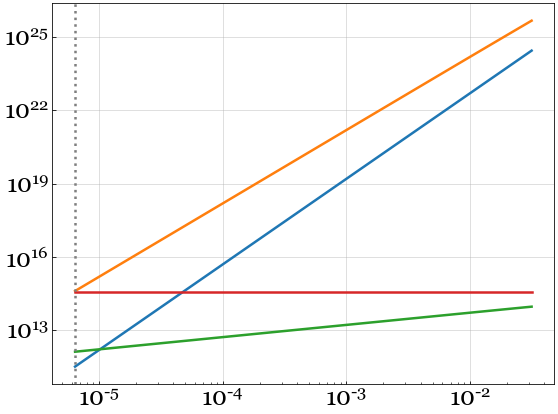

In [14]:
e_list = 1. - np.logspace(np.log10(1-ei_lim), -1.5, 100)
T_m_inst = get_inst_t_gw_from_a_orb(M1, M2, ai, e_list)
T_m_lk = get_inst_t_gw_from_a_orb(M1, M2, ai, 0)*(1.-e_list**2.)**3.

omega_i=np.sqrt(G*(M1+M2)/ai**3.)
T_lk = 1./omega_i * (M1+M2)/M3 * (ao/ai)**3.
T_lk_inst = T_lk * np.sqrt(1.-e_list**2.)

fig=plt.figure()
ax=fig.add_subplot(111)
ax.loglog(1.-e_list, T_m_inst)
ax.loglog(1.-e_list, T_m_lk)
ax.loglog(1.-e_list, T_lk_inst)
ax.loglog(1.-e_list, np.ones_like(e_list)*T_lk)

ax.axvline(1.-ei_lim, ls=':', color='tab:grey')

In [4]:
M1, M2, M3 = 85.*Ms, 65.*Ms, 1e9*Ms
ai, ao = 3.*AU, 0.06*pc
eo = 0
nPt = 500

ai_list = np.logspace(-0.5, 1.5, nPt)*AU
ao_list = np.logspace(-3., -1., nPt)*pc

ei_gw_var_ai = np.zeros(nPt)
ei_gw_var_ao = np.zeros(nPt)


ei_ref_var_ai = np.zeros(nPt)
ei_ref_var_ao = np.zeros(nPt)

ai_stb_flag = np.zeros(nPt)
ao_stb_flag = np.zeros(nPt)

for i in range(nPt):
#     print(ai_list[i]/AU, ao_list[i]/pc)

    try:
        ei_gw_var_ai[i] = find_ei_lim_t_gw_cut(M1, M2, M3, ai_list[i], ao)
        ei_ref_var_ai[i] = find_ei_lim_over_Ii_0(M1, M2, M3, ai_list[i], ao)
        ai_stb_flag[i] = check_stability(M1, M2, M3, ai_list[i], ao)
    
        ei_gw_var_ao[i] = find_ei_lim_t_gw_cut(M1, M2, M3, ai, ao_list[i])
        ei_ref_var_ao[i] = find_ei_lim_over_Ii_0(M1, M2, M3, ai, ao_list[i])
        ao_stb_flag[i] = check_stability(M1, M2, M3, ai, ao_list[i])
        
    except ValueError:
        ei_gw_var_ai[i] = np.inf
        ei_ref_var_ai[i] = np.inf
        ei_gw_var_ao[i] = np.inf
        ei_ref_var_ao[i] = np.inf
    


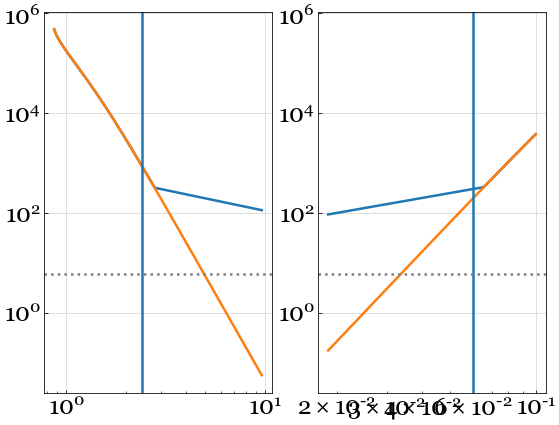

In [10]:
r_Mt = G*(M1+M2)/c**2.
fig=plt.figure()
ax=fig.add_subplot(121)

idx_ai_stb = ai_stb_flag > 0
idx_ai_us  = ai_stb_flag <= 0

idx_ao_stb = ao_stb_flag > 0
idx_ao_us  = ao_stb_flag <= 0

ax.loglog(ai_list[idx_ai_stb]/AU, (1.-ei_gw_var_ai[idx_ai_stb])*ai_list[idx_ai_stb]/r_Mt)
ax.loglog(ai_list[idx_ai_stb]/AU, (1.-ei_ref_var_ai[idx_ai_stb])*ai_list[idx_ai_stb]/r_Mt)
ax.axhline(6, ls=':', color='tab:grey')
ax.axvline(2.4)
ax=fig.add_subplot(122, sharey=ax)
ax.loglog(ao_list[idx_ao_stb]/pc, (1.-ei_gw_var_ao[idx_ao_stb])*ai/r_Mt)
ax.loglog(ao_list[idx_ao_stb]/pc, (1.-ei_ref_var_ao[idx_ao_stb])*ai/r_Mt)
ax.axvline(0.06)
ax.axhline(6, ls=':', color='tab:grey')


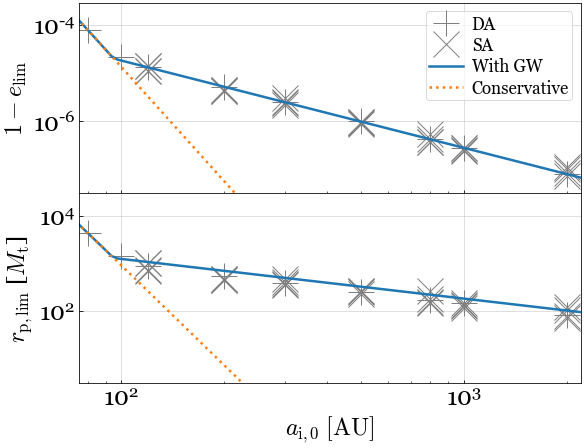

In [33]:
M1, M2, M3 = 85.*Ms, 65.*Ms, 1.e7*Ms

r_Mt=G*(M1+M2)/c**2.
ao = 1.*pc

nPt=100
ai0_plot = np.logspace(1.8, 3.5, nPt)*AU
e_max_gw = np.zeros(nPt)
e_max_con = np.zeros(nPt)
for i in range(nPt):
    e_max_gw[i]=find_ei_lim_t_gw_cut(M1, M2, M3, ai0_plot[i], ao, eo=0)
    e_max_con[i]=find_ei_lim_over_Ii_0(M1, M2, M3, ai0_plot[i], ao, eo=0)

max_ecc_data = np.loadtxt('max_ecc/data/max_ecc/M3_1.0e+07_ao_1.0e+00pc/max_e_var_ai.txt')
ai0_data = max_ecc_data[:, 0]
e_max_data = np.zeros([7, 5])
r_p_data = np.zeros([7, 5])
e_isco_data=np.zeros([7, 5])

for i in range(5):
    e_max_data[:, i] = 1.-max_ecc_data[:, 1+i*3]
    r_p_data[:, i] = max_ecc_data[:, 2+i*3]
    e_isco_data[:, i] = max_ecc_data[:, 3+i*3]
    
ai0_da_data=np.array([100, 80])
e_max_da_data=1.-np.array([2.152311e-05, 7.920277e-05])
r_p_da_data=ai0_da_data * (1.-e_max_da_data) * AU / r_Mt
    
fig=plt.figure()
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)

mk = ['+', 'x', 'x', 'x', 'x']
for i in range(5):
    if i==0:
        ax1.loglog(ai0_data, 1-e_max_data[:,i], ls='', marker=mk[i], color='tab:grey', ms=26, label=r'DA')
        ax2.loglog(ai0_data, r_p_data[:,i], ls='', marker=mk[i], color='tab:grey', ms=26, label=r'DA')
    elif i==1:
        ax1.loglog(ai0_data, 1-e_max_data[:,i], ls='', marker=mk[i], color='tab:grey', ms=26, label=r'SA')
        ax2.loglog(ai0_data, r_p_data[:,i], ls='', marker=mk[i], color='tab:grey', ms=26, label=r'SA')
    else:
        ax1.loglog(ai0_data, 1-e_max_data[:,i], ls='', marker=mk[i], color='tab:grey', ms=26)
        ax2.loglog(ai0_data, r_p_data[:,i], ls='', marker=mk[i], color='tab:grey', ms=26)
    

ax1.loglog(ai0_da_data, 1-e_max_da_data, ls='', marker=mk[0], color='tab:grey', ms=26)
ax2.loglog(ai0_da_data, r_p_da_data, ls='', marker=mk[0], color='tab:grey', ms=26)

ax1.loglog(ai0_plot/AU, 1.-e_max_gw, color='tab:blue', label=r'With GW')
ax1.loglog(ai0_plot/AU, 1.-e_max_con, color='tab:orange', ls=':',  label=r'Conservative')
ax1.set_ylim([3.e-8, 3.e-4])
ax1.set_xlim([75, 2200])

ax2.loglog(ai0_plot/AU, (1.-e_max_gw)*ai0_plot/r_Mt, color='tab:blue')
ax2.loglog(ai0_plot/AU, (1.-e_max_con)*ai0_plot/r_Mt, color='tab:orange', ls=':')
ax2.set_ylim([3.e0, 3.e4])
ax2.set_xlim([75, 2200])

ax1.legend()
ax1.set_ylabel(r'$1-e_{\rm lim}$')
ax2.set_ylabel(r'$r_{\rm p, lim}$ [$M_{\rm t}$]')
ax2.set_xlabel(r'$a_{\rm i, 0}$ $[{\rm AU}]$')
plt.subplots_adjust(hspace=0)
# plt.savefig('/home/hang.yu/public_html/astro/LK_evol/max_ecc/M3_1.0e+07_ao_1.0e+00pc/max_ecc_vs_ai.pdf')

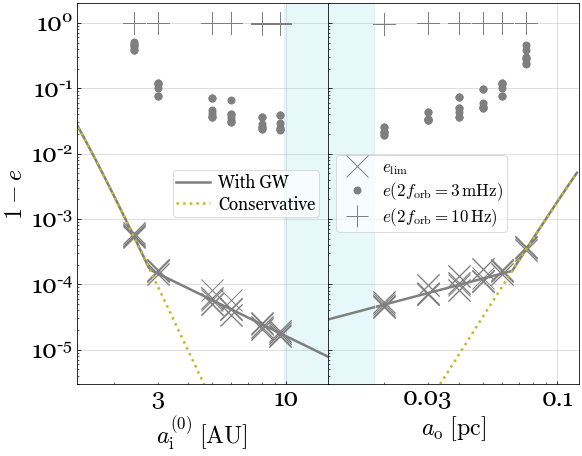

In [41]:
M1, M2, M3 = 85.*Ms, 65.*Ms, 1.e9*Ms

r_Mt=G*(M1+M2)/c**2.
ao = 0.06*pc
ai0 = 3.*AU

nPt=100
ai0_plot = np.logspace(np.log10(0.8), np.log10(22), nPt)*AU
ao_plot = np.logspace(np.log10(8.e-3), np.log10(0.12), nPt)*pc
e_max_gw_var_ai = np.zeros(nPt)
e_max_con_var_ai = np.zeros(nPt)
stb_var_ai = np.zeros(nPt)

e_max_gw_var_ao = np.zeros(nPt)
e_max_con_var_ao = np.zeros(nPt)
stb_var_ao = np.zeros(nPt)

for i in range(nPt):
    try:
        e_max_gw_var_ai[i]=find_ei_lim_t_gw_cut(M1, M2, M3, ai0_plot[i], ao, eo=0)
        e_max_con_var_ai[i]=find_ei_lim_over_Ii_0(M1, M2, M3, ai0_plot[i], ao, eo=0)
        stb_var_ai[i] = check_stability(M1, M2, M3, ai0_plot[i], ao, eo=0)
    except ValueError:
        e_max_gw_var_ai[i]=np.nan
        e_max_con_var_ai[i]=np.nan
    
    try:
        e_max_gw_var_ao[i]=find_ei_lim_t_gw_cut(M1, M2, M3, ai0, ao_plot[i], eo=0)
        e_max_con_var_ao[i]=find_ei_lim_over_Ii_0(M1, M2, M3, ai0, ao_plot[i], eo=0)
        stb_var_ao[i] = check_stability(M1, M2, M3, ai0, ao_plot[i], eo=0)
    except ValueError:
        e_max_gw_var_ao[i]=np.nan
        e_max_con_var_ao[i]=np.nan
    
data_var_ai = np.loadtxt('max_ecc/data/max_ecc/M3_1.0e+09_ao_6.0e-02pc//max_e_var_ai.txt')
data_var_ao = np.loadtxt('max_ecc/data/max_ecc/M3_1.0e+09_ai0_3.0e+00AU/max_e_var_ao.txt')
                        
ai0_var = data_var_ai[:, 0]
e_max_var_ai = np.zeros([6, 7])
e_3mHz_var_ai = np.zeros([6, 7])
e_10Hz_var_ai=np.zeros([6, 7])

ao_var = data_var_ao[:, 0]
e_max_var_ao = np.zeros([6, 7])
e_3mHz_var_ao = np.zeros([6, 7])
e_10Hz_var_ao=np.zeros([6, 7])

for i in range(7):
    e_max_var_ai[:, i] = 1.-data_var_ai[:, 1+i*5]
    e_3mHz_var_ai[:, i] = 1.-data_var_ai[:, 3+i*5]
    e_10Hz_var_ai[:, i] = 1.-data_var_ai[:, 5+i*5]
    
    e_max_var_ao[:, i] = 1.-data_var_ao[:, 1+i*5]
    e_3mHz_var_ao[:, i] = 1.-data_var_ao[:, 3+i*5]
    e_10Hz_var_ao[:, i] = 1.-data_var_ao[:, 5+i*5]
    

fig=plt.figure()
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

mk = ['+', 'x', 'x', 'x', 'x']
for i in range(7):
    if i==0:
        ax1.loglog(ai0_var, 1.-e_max_var_ai[:, i], ls='', marker='x', color='tab:grey', ms=22)
        ax1.loglog(ai0_var, 1.-e_3mHz_var_ai[:, i], ls='', marker='.', color='tab:grey', ms=14)
        ax1.loglog(ai0_var, 1.-e_10Hz_var_ai[:, i], ls='', marker='+', color='tab:grey', ms=22)
        
        ax2.loglog(ao_var, 1.-e_max_var_ao[:, i], ls='', marker='x', color='tab:grey', ms=22, label=r'$e_{\rm lim}$')
        ax2.loglog(ao_var, 1.-e_3mHz_var_ao[:, i], ls='', marker='.', color='tab:grey', ms=14, label=r'$e(2f_{\rm orb}=3\,{\rm mHz})$')
        ax2.loglog(ao_var, 1.-e_10Hz_var_ao[:, i], ls='', marker='+', color='tab:grey', ms=22, label=r'$e(2f_{\rm orb}=10\,{\rm Hz})$')
    else:
        ax1.loglog(ai0_var, 1.-e_max_var_ai[:, i], ls='', marker='x', color='tab:grey', ms=22)
        ax1.loglog(ai0_var, 1.-e_3mHz_var_ai[:, i], ls='', marker='.', color='tab:grey', ms=14)
        ax1.loglog(ai0_var, 1.-e_10Hz_var_ai[:, i], ls='', marker='+', color='tab:grey', ms=22)
        
        ax2.loglog(ao_var, 1.-e_max_var_ao[:, i], ls='', marker='x', color='tab:grey', ms=22)
        ax2.loglog(ao_var, 1.-e_3mHz_var_ao[:, i], ls='', marker='.', color='tab:grey', ms=14)
        ax2.loglog(ao_var, 1.-e_10Hz_var_ao[:, i], ls='', marker='+', color='tab:grey', ms=22)



idx_stb_var_ai = stb_var_ai > 0
idx_us_var_ai  = stb_var_ai <=0
ax1.loglog(ai0_plot[idx_stb_var_ai]/AU, 1.-e_max_gw_var_ai[idx_stb_var_ai], color='tab:grey', label=r'With GW')
ax1.loglog(ai0_plot[idx_stb_var_ai]/AU, 1.-e_max_con_var_ai[idx_stb_var_ai], color='tab:olive', label=r'Conservative', ls=':')
# ax1.loglog(ai0_plot[idx_stb_var_ai]/AU, 1.-e_max_gw_var_ai[idx_stb_var_ai], color='tab:grey', label=r'With GW')
ax1.loglog(ai0_plot[idx_us_var_ai]/AU, 1.-e_max_gw_var_ai[idx_us_var_ai], color='tab:grey', ls='-')
ax1.loglog(ai0_plot[idx_us_var_ai]/AU, 1.-e_max_con_var_ai[idx_us_var_ai], color='tab:olive', ls=':')
ax1.set_ylim([3.e-6, 2.])
ax1.set_xlim([1.4, 14.8])
ax1.xaxis.set_ticks([10])
ax1.xaxis.set_ticklabels([10])
ax1.xaxis.set_ticks([2, 3, 4, 5, 6, 7, 8, 9], minor=True)
ax1.xaxis.set_ticklabels(['', 3, '', '', '', '', '', ''], minor=True)

idx_stb_var_ao = stb_var_ao > 0
idx_us_var_ao  = stb_var_ao <=0
ax2.loglog(ao_plot[idx_stb_var_ao]/pc, 1.-e_max_gw_var_ao[idx_stb_var_ao], color='tab:grey')
ax2.loglog(ao_plot[idx_stb_var_ao]/pc, 1.-e_max_con_var_ao[idx_stb_var_ao], color='tab:olive', ls=':')
# ax2.loglog(ao_plot[idx_stb_var_ao]/pc, 1.-e_max_gw_var_ao[idx_stb_var_ao], color='tab:grey')
ax2.loglog(ao_plot[idx_us_var_ao]/pc, 1.-e_max_gw_var_ao[idx_us_var_ao], color='tab:grey', ls='-')
ax2.loglog(ao_plot[idx_us_var_ao]/pc, 1.-e_max_con_var_ao[idx_us_var_ao], color='tab:olive', ls=':')
ax2.set_ylim([3.e-6, 2.])
ax2.set_xlim([1.18e-2, 1.22e-1])
ax2.yaxis.set_ticklabels([])
ax2.xaxis.set_ticks([0.1])
ax2.xaxis.set_ticklabels([0.1])
ax2.xaxis.set_ticks([0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09], minor=True)
ax2.xaxis.set_ticklabels(['', 0.03, '', '', '', '', '', ''], minor=True)

ax1.fill_between(ai0_plot/AU, 0, 1, where=stb_var_ai<0,
                color='tab:cyan', alpha=0.1, transform=ax1.get_xaxis_transform())
ax2.fill_between(ao_plot/pc, 0, 1, where=stb_var_ao<0,
                color='tab:cyan', alpha=0.1, transform=ax2.get_xaxis_transform())

ax1.legend()
ax2.legend()

ax1.set_ylabel(r'$1-e$')
ax1.set_xlabel(r'$a_{\rm i}^{(0)}$ $[{\rm AU}]$')
ax2.set_xlabel(r'$a_{\rm o}$ $[{\rm pc}]$')
plt.subplots_adjust(wspace=0)
plt.savefig('/home/hang.yu/public_html/astro/LK_evol/max_ecc/max_ecc_vs_ai_ao.pdf')

In [28]:
M1, M2, M3 = 85.*Ms, 65.*Ms, 1.e9*Ms
Mt = M1 + M2
mu = M1*M2/(M1+M2)
qq = M2/M1

r_Mt = G*Mt/c**2.
S_Mt = G*Mt**2./c

par_aL = np.array([M1, M2])
int_func=lambda loga_, logL_:\
                evol_logL_vs_loga(loga_, logL_, par_aL)
 
r_10Hz = (G*Mt/(2.*np.pi*5.)**2.)**(1./3.)

ai0_plot = np.logspace(np.log10(8e-3), np.log10(14), 28)*AU
ao_plot = np.logspace(np.log10(8e-5), np.log10(0.14), 26)*pc

ao_exc = np.zeros(len(ai0_plot))
ao_stb = np.zeros(len(ai0_plot))

for i in range(len(ai0_plot)):
    resi = lambda ao_pc: check_stability(M1, M2, M3, ai0_plot[i], ao_pc*pc, eo=0.)
    ao_stb[i] = opt.fsolve(resi, 0.1)*pc
    
    resi = lambda ao_pc: check_LK_exc(M1, M2, M3, ai0_plot[i], ao_pc*pc, eo=0.)
    ao_exc[i] = opt.fsolve(resi, 0.1)*pc

ai0_mesh, ao_mesh = np.meshgrid(ai0_plot, ao_plot)
e_10Hz_mesh = np.zeros(ai0_mesh.shape)
stb_mesh = np.zeros(ai0_mesh.shape)
exc_mesh = np.zeros(ai0_mesh.shape)

for i in range(len(ai0_plot)):
    for j in range(len(ao_plot)):
        ai0, ao = ai0_plot[i], ao_plot[j]
        stb_flag = check_stability(M1, M2, M3, ai0, ao, eo=0.)
        exc_flag = check_LK_exc(M1, M2, M3, ai0, ao, eo=0.)
        
        if stb_flag<0:
            e_10Hz_mesh[j, i] = 0.05
            stb_mesh[j, i] = stb_flag
            
        if exc_flag<0.:
            e_10Hz_mesh[j, i] = 1.e-9
            exc_mesh[j, i] = exc_flag
            
        else:
            e_lim = find_ei_lim_t_gw_cut(M1, M2, M3, ai0, ao, eo=0)
#             print(1.-e_lim)
            L_init = mu * np.sqrt(G*Mt*ai0*(1.-e_lim**2.))
            
            sol=integ.solve_ivp(int_func, \
                    t_span=(np.log(ai0/r_Mt), np.log(r_10Hz/r_Mt)), y0=np.array([np.log(L_init/S_Mt)]), rtol=3e-14, atol=1e-17)
            
            L_10Hz = np.exp(sol.y[0, -1])*S_Mt
            a_10Hz_ref = np.exp(sol.t[-1])*r_Mt
            e_10Hz = L_10Hz / (mu*np.sqrt(G*Mt*r_10Hz))
            e_10Hz = np.sqrt(1.-e_10Hz**2.)
                
#             print(a_10Hz_ref/r_Mt, L_10Hz/S_Mt, e_10Hz)
            e_10Hz_mesh[j, i] = e_10Hz
        

/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:168: RuntimeWarning: invalid value encountered in sqrt
/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:177: RuntimeWarning: overflow encountered in double_scalars
/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:170: RuntimeWarning: overflow encountered in double_scalars
/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:175: RuntimeWarning: overflow encountered in power
/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:177: RuntimeWarning: overflow encountered in power
/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37

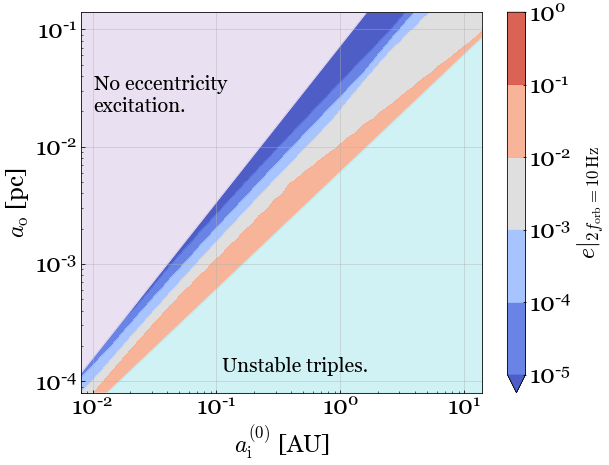

In [33]:
ai0_zoom = np.exp(ndimage.zoom(np.log(ai0_mesh/AU), 1))
ao_zoom = np.exp(ndimage.zoom(np.log(ao_mesh/pc), 1))
e_10Hz_zoom = np.exp(ndimage.zoom(np.log(e_10Hz_mesh), 1, mode='nearest'))

levels = np.logspace(-5, 0, 6)

fig=plt.figure()
ax=fig.add_subplot(111)

cs=ax.contourf(ai0_mesh/AU, ao_mesh/pc, \
               e_10Hz_mesh, levels=levels, extend='min', \
               cmap='coolwarm', alpha=0.9, \
               locator=LogLocator() 
               )

ax.fill_between(ai0_plot/AU, ao_exc/pc, np.max(ao_plot/pc), interpolate=True, color='white', alpha=1)
ax.fill_between(ai0_plot/AU, np.min(ao_plot/pc), ao_stb/pc, interpolate=True, color='white', alpha=1)

ax.fill_between(ai0_plot/AU, ao_exc/pc, np.max(ao_plot/pc), interpolate=True, color='tab:purple', alpha=0.2)
ax.fill_between(ai0_plot/AU, np.min(ao_plot/pc), ao_stb/pc, interpolate=True, color='tab:cyan', alpha=0.2)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$a_{\rm i}^{(0)}$ [AU]')
ax.set_ylabel(r'$a_{\rm o}$ [pc]')

ax.set_ylim([np.min(ao_plot/pc), np.max(ao_plot/pc)])
cbar=fig.colorbar(cs)
cbar.set_label(r'$e|_{2f_{\rm orb} {{=}} 10\,{\rm Hz}}$')

ax.text(1.02e-2, 2e-2, 'No eccentricity\nexcitation.')
ax.text(1.1e-1, 1.2e-4, 'Unstable triples.')

plt.savefig('/home/hang.yu/public_html/astro/LK_evol/max_ecc/max_ecc_10Hz.pdf')

In [37]:
print(np.max(e_10Hz_mesh), np.min(e_10Hz_mesh))

0.0473178069092905 0.0


In [86]:
M1, M2, M3 = 85.*Ms, 65.*Ms, 1.e7*Ms
r_Mt = G*(M1+M2)/c**2.
ai = np.array([30, 100, 300, 600]) * AU
n_ai = len(ai)

n_ao = 2000
ao = np.logspace(-1.8, 1.2, n_ao) * pc
Tgw_trgt= 10.e9 * P_yr

I_m, I_p = np.zeros([n_ai, n_ao]), np.zeros([n_ai, n_ao])
e_lim = np.zeros([n_ai, n_ao])
r_peri = np.zeros([n_ai, n_ao])

for i in range(n_ai):
    for j in range(n_ao):
#             print(ai[i]/AU, ao[j]/pc)
        try:
            I_m[i, j], I_p[i, j]=find_merger_window(10.e9*P_yr, \
                                    M1, M2, M3, ai[i], ao[j], eo)
        except ValueError:
            I_m[i,j], I_p[i,j]=np.inf, np.inf
            
#         print(I_m[i, j], I_p[i, j])
            
#         try:
#             e_lim[i, j] = find_ei_lim_over_Ii_0(M1, M2, M3, ai[i], ao[j], eo)
#             r_peri[i, j] = (1.-e_lim[i, j]) * ai[i]
#         except ValueError:
#             e_lim[i, j] = 0
#             r_peri[i, j] = np.inf
            

/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in double_scalars


88.0185109463808 91.98630217654625
89.11305430170783 90.89362008509175
89.574331337994 90.43555753316063
89.73229892184466 90.28085545774265


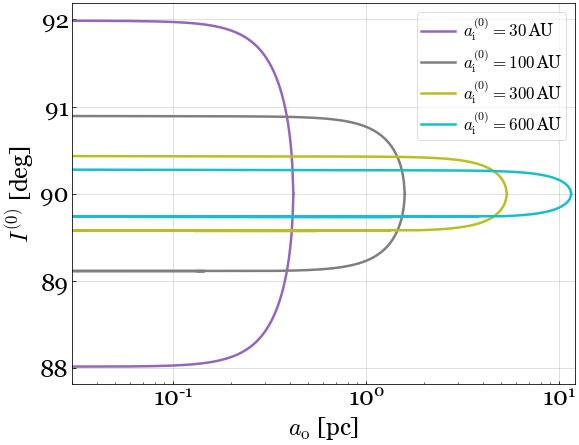

In [89]:
color=['tab:purple', 'tab:grey', 'tab:olive', 'tab:cyan']
r_Mt = G*(M1+M2)/c**2.
fig=plt.figure()
ax=fig.add_subplot(111)
for i in range(n_ai):
    idx_m = np.isfinite(I_m[i, :])
    idx_p = np.isfinite(I_p[i, :])
    ao_vs_I_m_func = interp.interp1d(I_m[i, idx_m]*180./np.pi, ao[idx_m]/pc, bounds_error=False, fill_value='extrapolate')
    ao_vs_I_p_func = interp.interp1d(I_p[i, idx_p]*180./np.pi, ao[idx_p]/pc, bounds_error=False, fill_value='extrapolate')
    
    I_ext = np.max([90.-np.min(I_m[i, idx_m]*180./np.pi), np.max(I_p[i, idx_p]*180./np.pi)-90.])
    print(np.min(I_m[i, idx_m]*180./np.pi), np.max(I_p[i, idx_p]*180./np.pi))
    I_m_plot = np.linspace(np.min(I_m[i, idx_m]*180./np.pi), 90, 1000)
    I_p_plot = np.linspace(90, np.max(I_p[i, idx_p]*180./np.pi), 1000)
#     I_m_plot = np.linspace(90.-I_ext, 90, 1000)
#     I_p_plot = np.linspace(90, 90.+I_ext, 1000)
    
    ax.plot(ao_vs_I_m_func(I_m_plot), I_m_plot, color=color[i], label=r'$a_{\rm i}^{(0)}=%.0f\,$AU'%(ai[i]/AU))
    ax.plot(ao_vs_I_p_func(I_p_plot), I_p_plot, color=color[i])
    
    # hacking
#     if i==1:
#         ax.plot([10.**(-1.1), ao_vs_I_m_func(np.array([89.11305430293761]))], \
#             np.array([89.111, 89.11305430293761]), color=color[i])
ax.set_xscale('log')
ax.set_xlabel(r'$a_{\rm o}$ [pc]')
ax.set_ylabel(r'$I^{(0)}$ [deg]')
ax.legend()
ax.set_xlim([.3e-1, 1.2e1])
plt.savefig('/home/hang.yu/public_html/astro/LK_evol/merg_win.pdf')

In [63]:
print(90-89.113, 90.891-90.)

0.8870000000000005 0.8910000000000053


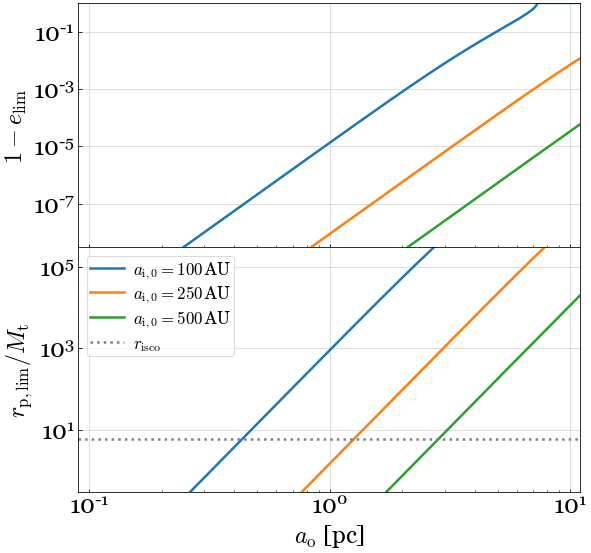

In [16]:
fig=plt.figure(figsize=(9,9))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)
for i in range(n_ai):
    ax1.loglog(ao/pc, 1-e_lim[i, :], color=color[i], label=r'$a_{\rm i, 0}=%.0f\,$AU'%(ai[i]/AU))
    ax2.loglog(ao/pc, r_peri[i, :]/r_Mt, color=color[i], label=r'$a_{\rm i, 0}=%.0f\,$AU'%(ai[i]/AU))

ax1.set_xlim([.9e-1, 1.1e1])
ax1.set_ylim([3.e-9, 1.02e0])
ax1.set_ylabel(r'$1-e_{\rm lim}$')
# ax1.legend()
ax1.set_xticklabels([])

ax2.set_xlim([.9e-1, 1.1e1])
ax2.set_ylim([0.3, 3.e5])
ax2.axhline(6, ls=':', color='tab:grey', label=r'$r_{\rm isco}$')
ax2.set_ylabel(r'$r_{\rm p, lim}/M_{\rm t}$')
ax2.set_xlabel(r'$a_{\rm o}$ [pc]')
ax2.legend()

plt.subplots_adjust(hspace=0)


In [61]:
M1, M2, M3 = 85.*Ms, 65.*Ms, 1.e7*Ms

n_ao, n_ai = 40, 20
ao_list = np.logspace(-1.2, 0.8, n_ao) * pc
ai_list = np.logspace(0.3, 2.7, n_ai) * AU

ao_grid, ai_grid = np.meshgrid(ao_list, ai_list)
Tgw_grid = np.zeros(ao_grid.shape)

for i in range(n_ai):
    for j in range(n_ao):
        flag_sta = check_stability(M1, M2, M3, ai_grid[i, j], ao_grid[i, j], eo)
        flag_exc = check_LK_exc(M1, M2, M3, ai_grid[i, j], ao_grid[i, j], eo)
#         print(ao_grid[i, j]/pc, ai_grid[i, j]/AU, flag_sta, flag_exc)
        if flag_sta<0:
            Tgw_grid[i, j] = -np.inf
        elif flag_exc<0:
            Tgw_grid[i, j] = np.inf
        else:
#             Tgw_grid[i, j] = find_Tgw_lim_over_Ii_0(M1, M2, M3, ai_grid[i, j], ao_grid[i, j], eo)
            try:
                Tgw_grid[i, j] = find_Tgw_lim_over_Ii_0(M1, M2, M3, ai_grid[i, j], ao_grid[i, j], eo)
            except ValueError:
                Tgw_grid[i, j] = 1.e3*P_yr


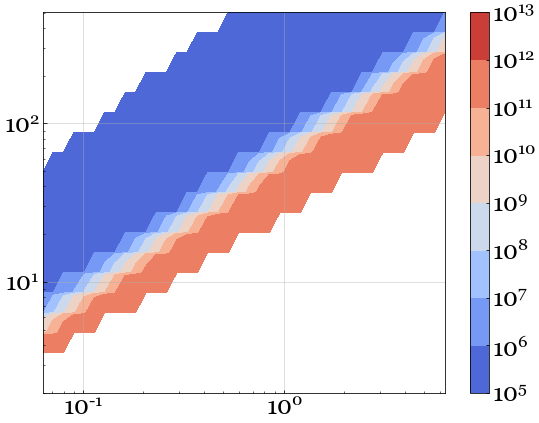

In [63]:
idx = (Tgw_grid<=(1.e6*P_yr)) & (Tgw_grid>-np.inf)
Tgw_grid[idx] = 1.e6*P_yr * np.ones_like(Tgw_grid[idx])

idx = (Tgw_grid>=(1.e12*P_yr)) & (Tgw_grid<np.inf)
Tgw_grid[idx] =1.e12*P_yr * np.ones_like(Tgw_grid[idx])

fig=plt.figure()
ax=fig.add_subplot(111)
cs=ax.contourf(ao_list/pc, ai_list/AU, Tgw_grid/P_yr, \
               locator=LogLocator(), cmap='coolwarm')
ax.set_xscale('log')
ax.set_yscale('log')
cbar = fig.colorbar(cs)

In [7]:
Mt = (85.+65.)*Ms
r_Mt = G*Mt/c**2.
r_600 = 600.*r_Mt
f_gw = np.sqrt(G*Mt/r_600**3.)/np.pi
print(f_gw)

0.014656655580383747


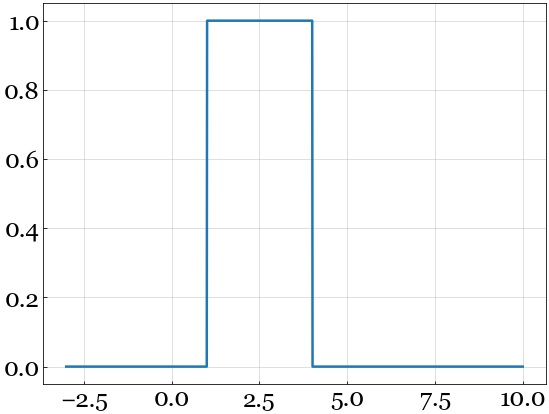

In [15]:
xx=np.arange(-3, 10, 0.01)
pdf = stats.uniform(loc=1., scale=3.).pdf(xx)

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(xx, pdf*3)

In [21]:
15.*4000/3600.

16.666666666666668

In [22]:
test = lambda x: x
opt.ridder(test, 1, 2)

ValueError: f(a) and f(b) must have different signs

In [62]:
1.2*pc/1000./AU * (1.e7/30)**(-1./3.)

3.56979906344725

In [88]:
Mt=150.*Ms
r_Mt=G*Mt/c**2.
rr = 10*r_Mt
np.sqrt(G*Mt/rr**3.)/np.pi

13.62359591374182

In [113]:
tau_ev = 3.2e7 * (150./2.)*(350./306.)/(10.)/(3)/(1.e7/2.1e6)
tau_2b = 1.6e10 * (350./306.)**3. / (10.) / (1.e7/2.1e6)
print('%e'%tau_2b)

5.027813e+08


In [104]:
rho_ref = (360.e5 * 0.1 *pc)**2./G/1.e9/Ms
print(rho_ref, rho_ref/(Ms/pc**3.))

929786377943468.6 1.373439386321288e+37


In [114]:
np.arange(0, 2.*np.pi, np.pi/3.)

array([0.        , 1.04719755, 2.0943951 , 3.14159265, 4.1887902 ,
       5.23598776])

In [25]:
500*AU/pc

0.0024240852966911884